# [TODO] compare for non-zero $k_x$

# [TODO] Implement winop for $n$ larger than 1

# [TODO] Check whether the W_root_plus and W_root_minus have same effect 

-> Yes, it seems so; the change of the sign doesn't seem to have effect on the resulting energy spectrum.
-> [TODO] need to be more rigorous to prove it

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['font.size'] = 13

# Configure Cooridnate

In [2]:
x_arr = np.linspace(-50,50,501)

# Define state function vector

In [3]:
sf_arr = np.empty_like(x_arr, dtype=complex)
from tdse.analytic import Gaussian1D
k_x = 1.0
sf_arr[:] = Gaussian1D(x_arr, t=0.0, k_x=k_x)

# Configure Hamiltonian

In [4]:
V_x_arr = np.zeros_like(x_arr, dtype=float)

# Configure window operator

In [5]:
winop_n=1
winop_gamma = 0.02

from nunit import au
au2ev = au.au2si['energy'] / au.e
print("Resolution: {:.2f} eV".format(winop_gamma * au2ev))

Resolution: 0.54 eV


# Construct energy array

In [6]:
E_min = -1.0
N_E = 100
E_arr = E_min + 2*winop_gamma*np.arange(N_E)

# Evaluate energy spectrum from `WINOP`

In [7]:
from tdse.winop import eval_energy_spectrum_for_1D_hamil
spectrum_E_arr = eval_energy_spectrum_for_1D_hamil(sf_arr, x_arr, V_x_arr, E_arr, winop_n, winop_gamma)

# Comparison to analytical result

In [8]:
pos_E_arr = E_arr[E_arr > 0]
pos_k_arr = np.sqrt(2.0*pos_E_arr)
from tdse.analytic import Gaussian1D_k_t0
spectrum_E_ana_arr = 1.0/pos_k_arr * (
    np.square( np.abs(Gaussian1D_k_t0(pos_k_arr, k_x)) ) 
    + np.square( np.abs(Gaussian1D_k_t0(-pos_k_arr, k_x)) )
)

In [9]:
spectrum_E_ana_arr_1 = 1.0/pos_k_arr * (
    np.square( np.abs(Gaussian1D_k_t0(pos_k_arr, 0)) ) 
    + np.square( np.abs(Gaussian1D_k_t0(-pos_k_arr, 0)) )
)

## Draw

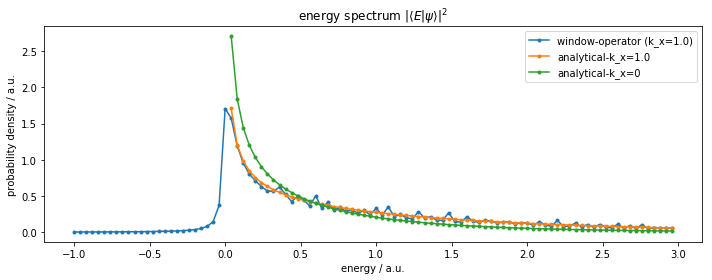

In [10]:
figE, axE = plt.subplots(figsize=(10,4))
li_winop, = axE.plot(E_arr, spectrum_E_arr, '.-')
li_ana, = axE.plot(pos_E_arr, spectrum_E_ana_arr, '.-')
li_ana_1, = axE.plot(pos_E_arr, spectrum_E_ana_arr_1, '.-')

axE.set_title(r"energy spectrum $|{\langle}E|\psi{\rangle}|^2$")
axE.set_xlabel("energy / a.u.")
axE.set_ylabel("probability density / a.u.")
axE.legend(
    (li_winop, li_ana, li_ana_1), 
    ("window-operator (k_x={:.1f})".format(k_x), "analytical-k_x={:.1f}".format(k_x), "analytical-k_x=0.0"))

figE.tight_layout()

In [11]:
# figE.savefig("winop-analytical-comparison-test-2.png")